### IMPORTS

In [167]:
import pandas as pd

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (accuracy_score, recall_score, precision_score, f1_score,
                             confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve, RocCurveDisplay, auc)
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_breast_cancer
from sklearn.svm import SVC

import matplotlib.pyplot as plt
import seaborn as sns
import copy as copy
import numpy as np

### INIT

In [168]:
data = load_breast_cancer()
x = data.data
y = data.target

In [169]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

### PRE PROCESSING

In [170]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

### TRAIN MODEL

In [171]:
knn = KNeighborsClassifier()
svm = SVC()

In [172]:
knn.fit(x_train, y_train)
svm.fit(x_train, y_train)

SVC()

### EVALUATE RESULTS

In [173]:
y_test_pred_knn = knn.predict(x_test)
y_test_pred_svm = svm.predict(x_test)

In [174]:
acc_test_knn = accuracy_score(y_test, y_test_pred_knn)
acc_test_svm = accuracy_score(y_test, y_test_pred_svm)

print(f"Acurácia KNN (teste): {acc_test_knn}")
print(f"Acurácia SVM (teste): {acc_test_svm}")

Acurácia KNN (teste): 0.956140350877193
Acurácia SVM (teste): 0.9736842105263158


In [175]:
cv_scores_knn = cross_val_score(knn, x_train, y_train, cv=5)
cv_scores_svm = cross_val_score(svm, x_train, y_train, cv=5)

print(f"Acurácia KNN (validação cruzada): {cv_scores_knn.mean()}")
print(f"Acurácia SVM (validação cruzada): {cv_scores_svm.mean()}")

Acurácia KNN (validação cruzada): 0.964835164835165
Acurácia SVM (validação cruzada): 0.9670329670329669


### VISUALIZATION

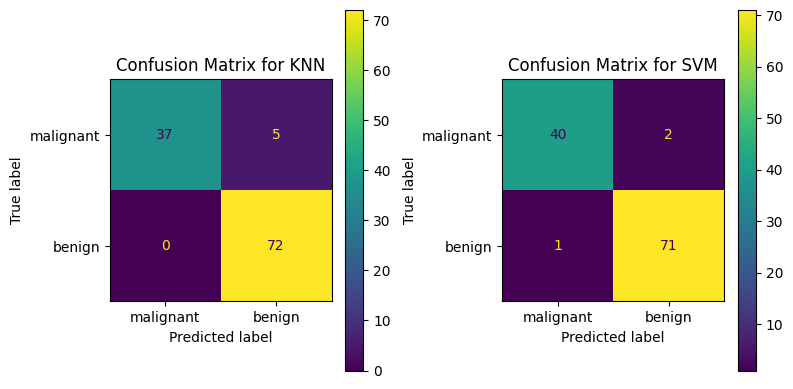

In [176]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

cm_knn = confusion_matrix(y_test, y_test_pred_knn)
disp_knn = ConfusionMatrixDisplay(cm_knn, display_labels=data.target_names)
disp_knn.plot(ax=axes[0])
axes[0].set_title('Confusion Matrix for KNN')

cm_svm = confusion_matrix(y_test, y_test_pred_svm)
disp_svm = ConfusionMatrixDisplay(cm_svm, display_labels=data.target_names)
disp_svm.plot(ax=axes[1])
axes[1].set_title('Confusion Matrix for SVM')

plt.tight_layout()
plt.show()

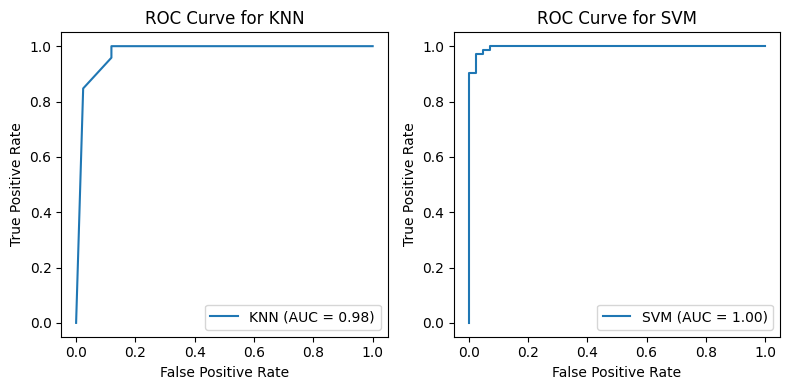

In [177]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# ROC Curve for KNN
fpr_knn, tpr_knn, _ = roc_curve(y_test, knn.predict_proba(x_test)[:, 1])
roc_auc_knn = auc(fpr_knn, tpr_knn)
RocCurveDisplay(fpr=fpr_knn, tpr=tpr_knn, roc_auc=roc_auc_knn, estimator_name='KNN').plot(ax=axes[0])
axes[0].set_title('ROC Curve for KNN')

# ROC Curve for SVM
fpr_svm, tpr_svm, _ = roc_curve(y_test, svm.decision_function(x_test))
roc_auc_svm = auc(fpr_svm, tpr_svm)
RocCurveDisplay(fpr=fpr_svm, tpr=tpr_svm, roc_auc=roc_auc_svm, estimator_name='SVM').plot(ax=axes[1])
axes[1].set_title('ROC Curve for SVM')

plt.tight_layout()
plt.show()

### PARAMETER ADJUSTMENTS

In [178]:
param_grid_knn = {'n_neighbors': range(1, 51, 2)}
param_grid_svm = {'C': [0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1]}

grid_knn = GridSearchCV(knn, param_grid_knn, cv=5)
grid_svm = GridSearchCV(svm, param_grid_svm, cv=5)

grid_knn.fit(x_train, y_train)
grid_svm.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100],
                         'gamma': [0.001, 0.01, 0.1, 1]})

In [179]:
print(f"Melhores parâmetros KNN: {grid_knn.best_params_}")
print(f"Melhores parâmetros SVM: {grid_svm.best_params_}")

Melhores parâmetros KNN: {'n_neighbors': 3}
Melhores parâmetros SVM: {'C': 100, 'gamma': 0.001}


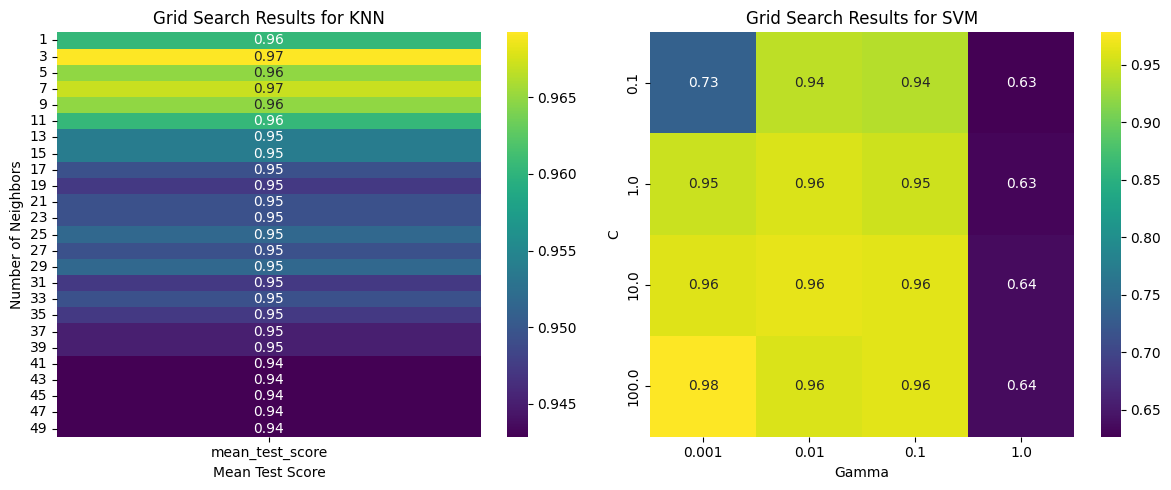

In [180]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

grid_results_knn = pd.DataFrame(grid_knn.cv_results_)
grid_results_svm = pd.DataFrame(grid_svm.cv_results_)

pivot_knn = grid_results_knn.pivot_table(index='param_n_neighbors', values='mean_test_score')
sns.heatmap(pivot_knn, annot=True, cmap='viridis', ax=axes[0])
axes[0].set_title('Grid Search Results for KNN')
axes[0].set_xlabel('Mean Test Score')
axes[0].set_ylabel('Number of Neighbors')

pivot_svm = grid_results_svm.pivot_table(index='param_C', columns='param_gamma', values='mean_test_score')
sns.heatmap(pivot_svm, annot=True, cmap='viridis', ax=axes[1])
axes[1].set_title('Grid Search Results for SVM')
axes[1].set_xlabel('Gamma')
axes[1].set_ylabel('C')

plt.tight_layout()
plt.show()

### RE-TRAIN MODEL WITH ADJUSTMENTS

In [181]:
knn_best = grid_knn.best_estimator_
svm_best = grid_svm.best_estimator_

In [182]:
knn_best.fit(x_train, y_train)
svm_best.fit(x_train, y_train)

SVC(C=100, gamma=0.001)

### RE-EVALUATE RESULTS

In [183]:
y_test_pred_knn_best = knn_best.predict(x_test)
y_test_pred_svm_best = svm_best.predict(x_test)

In [184]:
acc_test_knn_best = accuracy_score(y_test, y_test_pred_knn_best)
acc_test_svm_best = accuracy_score(y_test, y_test_pred_svm_best)

print(f"Acurácia KNN ajustado (teste): {acc_test_knn_best}")
print(f"Acurácia SVM ajustado (teste): {acc_test_svm_best}")

Acurácia KNN ajustado (teste): 0.9473684210526315
Acurácia SVM ajustado (teste): 0.9649122807017544


In [185]:
cv_scores_knn_best = cross_val_score(knn_best, x_train, y_train, cv=5)
cv_scores_svm_best = cross_val_score(svm_best, x_train, y_train, cv=5)

print(f"Acurácia KNN (validação cruzada): {cv_scores_knn_best.mean()}")
print(f"Acurácia SVM (validação cruzada): {cv_scores_svm_best.mean()}")

Acurácia KNN (validação cruzada): 0.9692307692307693
Acurácia SVM (validação cruzada): 0.9780219780219781


### VISUALIZATION

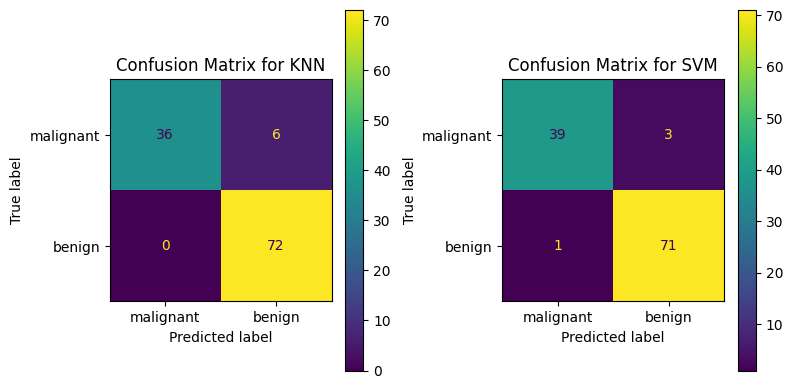

In [186]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

cm_knn = confusion_matrix(y_test, y_test_pred_knn_best)
disp_knn = ConfusionMatrixDisplay(cm_knn, display_labels=data.target_names)
disp_knn.plot(ax=axes[0])
axes[0].set_title('Confusion Matrix for KNN')

cm_svm = confusion_matrix(y_test, y_test_pred_svm_best)
disp_svm = ConfusionMatrixDisplay(cm_svm, display_labels=data.target_names)
disp_svm.plot(ax=axes[1])
axes[1].set_title('Confusion Matrix for SVM')

plt.tight_layout()
plt.show()

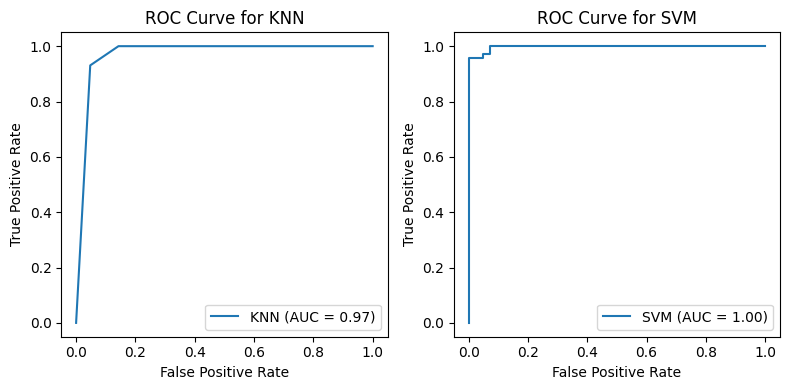

In [187]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# ROC Curve for KNN
fpr_knn, tpr_knn, _ = roc_curve(y_test, knn_best.predict_proba(x_test)[:, 1])
roc_auc_knn = auc(fpr_knn, tpr_knn)
RocCurveDisplay(fpr=fpr_knn, tpr=tpr_knn, roc_auc=roc_auc_knn, estimator_name='KNN').plot(ax=axes[0])
axes[0].set_title('ROC Curve for KNN')

# ROC Curve for SVM
fpr_svm, tpr_svm, _ = roc_curve(y_test, svm_best.decision_function(x_test))
roc_auc_svm = auc(fpr_svm, tpr_svm)
RocCurveDisplay(fpr=fpr_svm, tpr=tpr_svm, roc_auc=roc_auc_svm, estimator_name='SVM').plot(ax=axes[1])
axes[1].set_title('ROC Curve for SVM')

plt.tight_layout()
plt.show()

### COMPARISON

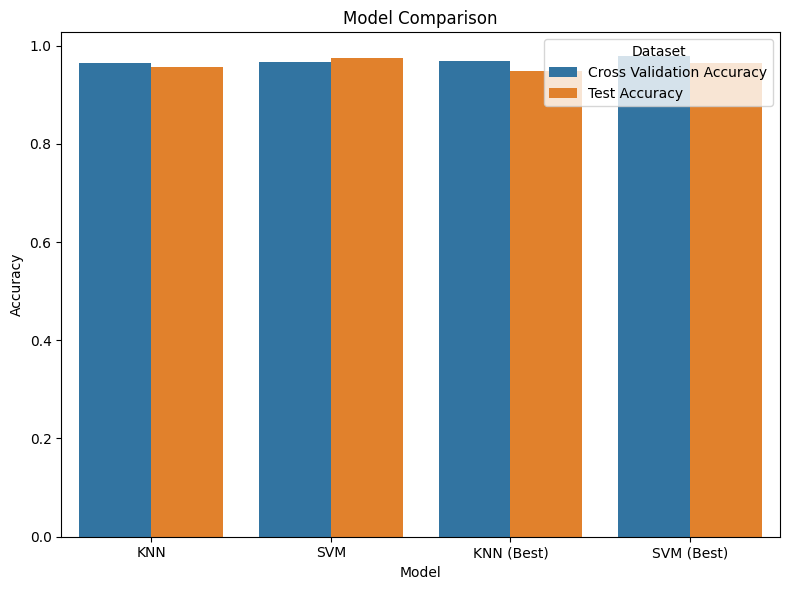

In [189]:
fig, ax = plt.subplots(figsize=(8, 6))

results = {
    'Model': ['KNN', 'SVM', 'KNN (Best)', 'SVM (Best)'],
    'Cross Validation Accuracy': [cv_scores_knn.mean(), cv_scores_svm.mean(), cv_scores_knn_best.mean(), cv_scores_svm_best.mean()],
    'Test Accuracy': [acc_test_knn, acc_test_svm, acc_test_knn_best, acc_test_svm_best]
}
results_df = pd.DataFrame(results)
results_df = results_df.melt(id_vars='Model', var_name='Dataset', value_name='Accuracy')

sns.barplot(x='Model', y='Accuracy', hue='Dataset', data=results_df, ax=ax)
ax.set_title('Model Comparison')
plt.tight_layout()
plt.show()